# _Keyword Spotting_ usando redes convolucionais

## Introdução

_Keyword Spotting_ é uma técnica de detecção de palavras chaves pré-definidas em um falas continuadas [1]. É muito utilizado no contexto de reconhecimento de fala nos _wake word systems_, tal como o "_Ok Google!_" dos dispositivos **Android** [2]. Neste documento, é apresentado uma solução em _Keyword Spotting_ usando redes neurais artificiais convolucionais. 

### _Dataset_

O _dataset_ utilizado no projeto é o **_DARPA TIMIT_**, conhecido na literatura e utilizado em algumas publicações [3-5]. Este _dataset_ é dividido em locutores e por texto, onde o usuário tem acesso aos arquivos `.WAV`, à transcrição e também as indexações por palavras e por fonemas.

Neste trabalho é utilizado as indexações por palavras e também os arquivos `.WAV` contidos no _dataset_.  

### Divisão do _dataset_

O _dataset_ é dividido em dois blocos: treinamento e teste.
A classificação é realizda através de duas classes: palavras fora do vocabulário (**OOV**) e palavra-chave (**KW**)

### _Features_

Para a extração de _features_ dos trechos de áudio, correspondentes a OOV e KW, é utilizado uma matriz de **_Mel Frequency Cepstrum Coefficients_** (MFCC). Cada coluna da matriz representa uma extração MFCC de um subtrecho do trecho de áudio.

Os MFCCs são extraidos a partir dos parametros:
```python
fs = 16000 # taxa de amostragem dos arquivos de audio

n_fft= 512   # tamanho da FFT para extração dos MFCCs
hop_length=0 # pulo entre cada frame
n_mels= 50   # numero de filtros MEL
n_mfcc= 15   # numero de coeficientes MFFC
ofs_mfcc=2   # offset dado para não utilizar os primeiros coeficientes MFCC      

fmin=100    # frequencia mínima do MFCC
fmax=4000   # frequencia máxima do MFCC

n_frames_MFCC = 10 # numero de frames MFCC que será usado para o reconhecimento.

frame_len = (n_frames_MFCC-1)*n_fft # tamanho do frame recortado para cada entrada
frame_lenD2 = int(frame_len/2) # tamanho do frame dividido por 2
```

Para a extração dos MFCCs, é utilizado a biblioteca ```librosa```
```python
import librosa```

### Rede Neural

O treinamento da Rede Neural é realizado utilizando a biblioteca ```keras```
```python
import keras```


## Código

Na sequência é apresentado o código realizado para extração de _features_, treinamento e teste da Rede Neural.

### Declaração de bibliotecas

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa

from scipy.io.wavfile import read as wavread
from scipy.io.wavfile import write as wavwrite

import os, time

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

/home/usrp/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Declaração de _PATHs_

Aqui é declarado os caminhos para que estão armazenados o _dataset_ e onde estará armazenada as _features_ de KW e OOV.

Também é declarado a _keyword_ escolhida.

In [69]:
TRAIN_DIR_TIMIT = 'TRAIN'
TRAIN_DIR_KW = os.path.join('data','train','kw')
TRAIN_DIR_OOV = os.path.join('data','train','oov')

TEST_DIR_TIMIT = 'TEST'
TEST_DIR_KW = os.path.join('data','test','kw')
TEST_DIR_OOV = os.path.join('data','test','oov')

# keyword escolhida
KEYWORD = 'you'

### Declaração de constantes MFCC

Aqui são declaradas as constantes utilizadas na extração de _features_ MFCC dos trechos de áudio.

In [ ]:
fs = 16000 # taxa de amostragem dos arquivos de audio

n_fft= 512   # tamanho da FFT para extração dos MFCCs
hop_length=0 # pulo entre cada frame
n_mels= 50   # numero de filtros MEL
n_mfcc= 15   # numero de coeficientes MFFC
ofs_mfcc=2   # offset dado para não utilizar os primeiros coeficientes MFCC      

fmin=100    # frequencia mínima do MFCC
fmax=4000   # frequencia máxima do MFCC

n_frames_MFCC = 10 # numero de frames MFCC que será usado para o reconhecimento.

frame_len = (n_frames_MFCC-1)*n_fft # tamanho do frame recortado para cada entrada
frame_lenD2 = int(frame_len/2) # tamanho do frame dividido por 2

# Extração de _features_

Nesta etapa é extraido as _features_ dos exemplos de áudio do _dataset_ **DARPA TIMIT**

1. Inicialmente, é gerado as pastas que serão armazenadas as _features_

2. Na sequência, é percorrido, através de um ```for```, todas as pastas do _dataset_ **DARPA TIMIT**

3. Posteriormente, é analisado cada arquivo _.WRD_, encontrando exemplos da _keyword_ escolhida através do parâmetro ```KEYWORD```. Em cada exemplo, é extraido dos arquivos _.WAV_ os trechos correspondentes a _keyword_ e realizada a extração dos MFCCs do exemplo.

4. Agora, de forma aleatória, é escolhido ```OOV_N``` exemplos de OOV de cada arquivo de áudio.

5. Finalmente, são salvas as listas que contém as _features_, as matrizes MFCC (OOV e KW), que serão utilizadas no treinamento da rede neural.



In [199]:
DIR = (TRAIN_DIR_TIMIT, TRAIN_DIR_KW, TRAIN_DIR_OOV)

# se nao existe, gera as pastas
if not os.path.isdir(DIR[1]):
    os.makedirs(DIR[1])
if not os.path.isdir(DIR[2]):
    os.makedirs(DIR[2])

# declara as variaveis utilizadas no laço
start = time.time()
print('Inicio em', start)
wrd_list = []
# 2. percorre por todos os arquivos de audio do dataset
for path, dirs, files in os.walk(DIR[0]):
    for file in files:
        # encontra os arquivos .WRD
        if file.endswith('WRD'):
            # .wav
            fullFileName = os.path.join(path, file)
            fnameNoSuffix = os.path.splitext(fullFileName)[0]

            # abre o arquvo .WRD
            text = open(fullFileName,'r')
            for line in text.read().splitlines():
                word = line.split(' ')[2] # adquire a terceira palavra da linha
                wrd_list.append(word) # armazena em uma word list

Inicio em 1530656743.8564048


In [213]:
len([i for i, x in enumerate(wrd_list) if x == "blue"])

3

In [67]:
def extract_MFCC_TIMIT(typeDIR='train'):
    if typeDIR=='train':
        DIR = (TRAIN_DIR_TIMIT, TRAIN_DIR_KW, TRAIN_DIR_OOV)
    else:
        DIR = (TEST_DIR_TIMIT, TEST_DIR_KW, TEST_DIR_OOV)
    # 1.
    # se nao existe, gera as pastas
    if not os.path.isdir(DIR[1]):
        os.makedirs(DIR[1])
    if not os.path.isdir(DIR[2]):
        os.makedirs(DIR[2])

    # declara as variaveis utilizadas no laço
    start = time.time()
    print('Inicio em', start)
    cnt = 0
    wrd_list = []
    cnt_kw = 0
    cnt_oov = 0
    OOV_N = 5
    cnt_dirs = 0
    kw_MFCC = []
    oov_MFCC = []
    # 2. percorre por todos os arquivos de audio do dataset
    for path, dirs, files in os.walk(DIR[0]):
    #     kw_MFCC = []
    #     oov_MFCC = []
        for file in files:
            # encontra os arquivos .WRD
            if file.endswith('WRD'):
                # .wav
                fullFileName = os.path.join(path, file)
                fnameNoSuffix = os.path.splitext(fullFileName)[0]

                [data_file, _] = librosa.load(fnameNoSuffix + '.WAV') # Lê todo o arquivo de audio
                N = data_file.shape[0]  # indica o tamanho do arquivo

                # abre o arquvo .WRD
                text = open(fullFileName,'r')
                have_KW = False
                center = 1e12
                # 3.
                # no arquivo .WRD, le todas as linhas
                for line in text.read().splitlines():
                    word = line.split(' ')[2] # adquire a terceira palavra da linha
                    wrd_list.append(word) # armazena em uma word list

                    # se encontrar uma keyword
                    if word == KEYWORD:
                        # encontra o centro da keyword
                        center = int((int(line.split(' ')[0]) + int(line.split(' ')[1]))/2)
                        have_KW = True

                        # verifica se os o frame está dentro dos limites do arquivo de audio
                        # e extrai o trecho de audio contendo a KW
                        if center < frame_lenD2:
                            frameSample = np.concatenate((np.zeros(frame_lenD2-center), data_file[0:center+frame_lenD2]))
                        else:
                            frameSample = data_file[center-frame_lenD2:center+frame_lenD2]

                        # extrai os MFCCs do trecho contendo a KW
                        MFCCsample = librosa.feature.mfcc(y=frameSample, sr=fs, fmin=fmin, fmax=fmax, 
                                                             n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft)

                        # armazena em uma lista
                        kw_MFCC.append(MFCCsample[ofs_mfcc:])
                        # conta o numero de trechos MFCC KW extraidos
                        cnt_kw+=1

                # 4.
                # executa o laco OOV_N vezes 
                for p in range(OOV_N):
                    goodId = False
                    while goodId == False:
                        # escolhe um indice aleatorio para centro do trecho OOV 
                        # dentro do arquivo de audio
                        idx = np.random.randint(N-frame_len)+frame_lenD2 # gera numero aleatorio
                        goodId = True

    #                     for j in range(len(center)): # analisa o indice criado com os indices das kw
    #                         if abs(idx-iAbre[i][j]) < frame_len:
    #                             goodId = False

                        # se bater com o trecho da KW, escolhe outro
                        if abs(idx-center) < frame_len:
                            goodId = False

                        # extrai o trecho de audio
                        frameSample = data_file[idx-frame_lenD2:idx+frame_lenD2]

                        # extrai os MFCCs
                        MFCCsample = librosa.feature.mfcc(y=frameSample, sr=fs, fmin=fmin, fmax=fmax, 
                                                             n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft)

                        # salva em uma lista
                        oov_MFCC.append(MFCCsample[ofs_mfcc:])

                        # conta o numero de trechos MFCC OOV extraidos
                        cnt_oov+=1

    #             if cnt_oov > 50:
    #                 break
    #     if cnt_oov > 50:
    #         break

    #     cnt_dirs += 1
    #     if cnt_dirs == 10:
    #         break

    #     if  kw_MFCC != []:
    #         featFileName = os.path.join(DIR[1], fnameNoSuffix.split(os.sep)[-2] + '-' + fnameNoSuffix.split(os.sep)[-1] + '.npy')
    #     #     featFileName = os.path.join(DIR[1], 'KW_MFCCs.npy')
    #         np.save(featFileName, kw_MFCC)

    #     featFileName = os.path.join(DIR[2], fnameNoSuffix.split(os.sep)[-2] + '-' + fnameNoSuffix.split(os.sep)[-1] + '.npy')
    #     #     featFileName = os.path.join(DIR[2], 'OOV_MFCCs.npy')
    #     np.save(featFileName, oov_MFCC)

    ##### Salva os arquivos e imprimi a duração da extração dos MFCC do dataset

    # featFileName = os.path.join(DIR[1], fnameNoSuffix.split(os.sep)[-2] + '-' + fnameNoSuffix.split(os.sep)[-1] + '.npy')
    featFileName = os.path.join(DIR[1], 'KW_MFCCs.npy')
    np.save(featFileName, kw_MFCC)

    # featFileName = os.path.join(DIR[2], fnameNoSuffix.split(os.sep)[-2] + '-' + fnameNoSuffix.split(os.sep)[-1] + '.npy')
    featFileName = os.path.join(DIR[2], 'OOV_MFCCs.npy')
    np.save(featFileName, oov_MFCC)

    fim = time.time()
    print('Fim em', fim)
    print('\n{}: \n\nKW examples: {}\nOOV examples: {}\n\nduration: {:.0f}s'.format(typeDIR, cnt_kw, cnt_oov, (time.time()-start)))

In [71]:
extract_MFCC_TIMIT(typeDIR='train')

Inicio em 1530649091.7711096
Fim em 1530650297.3983436

train: 

KW examples: 274
OOV examples: 23386

duration: 1206s


In [70]:
extract_MFCC_TIMIT(typeDIR='test')

Inicio em 1530648174.6324682
Fim em 1530648642.7034981

test: 

KW examples: 88
OOV examples: 8492

duration: 468s


In [177]:
kw_MFCC = np.load(os.path.join(TRAIN_DIR_KW, 'KW_MFCCs.npy'))

In [178]:
oov_MFCC = np.load(os.path.join(TRAIN_DIR_OOV, 'OOV_MFCCs.npy'))

### Exemplos

As figuras abaixo apresentam exemplos das matrizes MFCC, as _features_, geradas na etapa anterior


Aqui é apresentado a matriz MFCC da keyword numero 100 




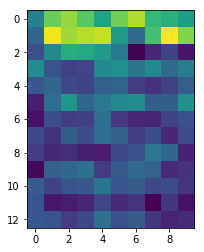

In [155]:
i=100
print('\nAqui é apresentado a matriz MFCC da keyword numero', i, '\n\n')

plt.imshow(kw_MFCC[i])


Aqui é apresentado a matriz MFCC da OOV numero 40 




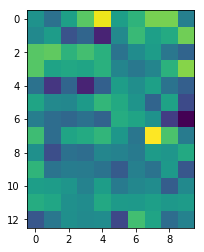

In [156]:
i=40
print('\nAqui é apresentado a matriz MFCC da OOV numero', i, '\n\n')

plt.imshow(oov_MFCC[i])

## _Split Data_

A função abaixo é utilizada para embaralhar e separar o conjunto de dados. 
Neste trabalho, é utilizada apenas para para embaralhar o conjunto de treinamento. 

In [157]:
def splitData(x, y, p=0.2): 
    shapeInX = x.shape
    shapeInY = y.shape
    datax = x.reshape(shapeInX[0],-1)
    
    data = np.concatenate((datax, y), axis=1)
    # random.randint(0, int(x.shape[0]*(1-p)))
    xScrambled = np.random.permutation(data)
    nLines = xScrambled.shape[0]

    data_train = xScrambled[0:int(round(nLines*(1-p))), :]
    data_test = xScrambled[int(round(nLines*(1-p))):, :]
#     print(nLines)
#     print(data_train.shape)
    
    shape_train = np.asarray(shapeInX)
    shape_train[0] = data_train.shape[0]
    x_train = data_train[:,:data_train.shape[1]-shapeInY[1]].reshape(tuple(shape_train))
    y_train = data_train[:,[data_train.shape[1]-shapeInY[1]]]
    
    
    shape_test = np.asarray(shapeInX)
    shape_test[0] = data_test.shape[0]
    x_test = data_test[:,:data_test.shape[1]-shapeInY[1]].reshape(tuple(shape_test))
    y_test = data_test[:,data_test.shape[1]-shapeInY[1]:]
    
    
    return (x_train, y_train), (x_test, y_test)


Embaralha o conjunto as _features_ OOV e KW para gerar os dados de treinamento: ```(x_train, y_train)```

In [214]:
OOV_uses = 5000
oov_MFCC = oov_MFCC[:OOV_uses]

y_OOV = np.zeros((len(oov_MFCC),  1))
y_KW = np.ones((len(kw_MFCC),  1))

(x_train, y_train), _ = splitData(
            np.concatenate((np.array(kw_MFCC), 
                           np.array(kw_MFCC), np.array(oov_MFCC)), axis=0), 
            np.concatenate((np.array(y_KW), 
                           np.array(y_KW), np.array(y_OOV)), axis=0), p=0)

x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
# print(y_train[:300])
print(x_train.shape)

(1548, 13, 10, 1)


## Rede Neural Convolucional

É utilizado neste trabalho uma Rede Neural Convolucional para classificar as _keywords_ e as OOVs.

Em [9] é explorado o uso de _convolutional neural networks_ (CNN)
em sistemas de _keyword spotting_. É apresentado um ganho relativo
de 27-44% de _false reject rate_ comparado com _dense neural networks_
(DNN). Tais comparações foram realizadas observando o número de
parâmetros e multiplicações realizadas, mostrando que as CNNs utilizam muito menos parâmetros e multiplicações.

In [215]:
import keras
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout
from keras.models import Sequential

input_shape = x_train.shape[1:]
num_classes = 2

print(input_shape)
y_train_ce = keras.utils.to_categorical(y_train.reshape(-1), num_classes)

(13, 10, 1)


### Criação do Modelo

Abaixo é declarada a estrutura do modelo da Rede Neural que será utilizada. 

O Sumário do modelo da rede é apresentado na sequência

In [188]:
model = Sequential()
model.add(Conv2D(7, kernel_size=(5, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
# model.add(Conv2D(4, kernel_size=(3, 4), strides=(1, 1),
#                  activation='relu'))
# model.add(Conv2D(3, kernel_size=(2, 4), strides=(1, 1),
#                  activation='relu'))
# model.add(Conv2D(3, kernel_size=(2, 4), strides=(1, 1),
#                  activation='relu'))
model.add(Conv2D(10, kernel_size=(4, 2), strides=(1, 1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(10, kernel_size=(2, 2), strides=(1, 1),
                 activation='relu'))
# model.add(Conv2D(2, kernel_size=(2, 4), strides=(1, 1),
#                  activation='relu',
#                  input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# model.add(Conv2D(4, (2, 2), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
# model.add(Dense(10, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('************************ SUMÁRIO DA REDE ************************\n\n')
model.summary()

************************ SUMÁRIO DA REDE ************************


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 9, 8, 7)           112       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 6, 7, 10)          570       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 3, 3, 10)          0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 2, 2, 10)          410       
_________________________________________________________________
flatten_16 (Flatten)         (None, 40)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 82        
Total params: 1,174
Trainable params: 1,174
Non-trainable params: 0
______

In [216]:
class_weight = {0: 1.,
                1: 1.}

history = model.fit(x_train, y_train_ce,
          validation_split=0.1,
          epochs=10,
          batch_size=128,
          class_weight=class_weight,
          verbose=2,
                   )
print('\nNeural Network Trained! \n\n')


Train on 1393 samples, validate on 155 samples
Epoch 1/10
 - 0s - loss: 0.3567 - acc: 0.9390 - val_loss: 0.6757 - val_acc: 0.8774
Epoch 2/10
 - 0s - loss: 0.3400 - acc: 0.9246 - val_loss: 0.4159 - val_acc: 0.9290
Epoch 3/10
 - 0s - loss: 0.2557 - acc: 0.9304 - val_loss: 0.3501 - val_acc: 0.9226
Epoch 4/10
 - 0s - loss: 0.1308 - acc: 0.9627 - val_loss: 0.2792 - val_acc: 0.9419
Epoch 5/10
 - 0s - loss: 0.1060 - acc: 0.9821 - val_loss: 0.2480 - val_acc: 0.9484
Epoch 6/10
 - 0s - loss: 0.0738 - acc: 0.9864 - val_loss: 0.1945 - val_acc: 0.9742
Epoch 7/10
 - 0s - loss: 0.0572 - acc: 0.9914 - val_loss: 0.1593 - val_acc: 0.9871
Epoch 8/10
 - 0s - loss: 0.0492 - acc: 0.9943 - val_loss: 0.1399 - val_acc: 0.9871
Epoch 9/10
 - 0s - loss: 0.0434 - acc: 0.9971 - val_loss: 0.1420 - val_acc: 0.9871
Epoch 10/10
 - 0s - loss: 0.0401 - acc: 0.9971 - val_loss: 0.1433 - val_acc: 0.9871

Neural Network Trained! 




## Analise do desempenho 

Neste etapa, é analisado o desempenho da rede neural utilizando o conjunto de teste.

In [197]:
kw_MFCC2 = np.load(os.path.join(TEST_DIR_KW, 'KW_MFCCs.npy'))
oov_MFCC2 = np.load(os.path.join(TEST_DIR_OOV, 'OOV_MFCCs.npy'))

y_OOV = np.zeros((len(oov_MFCC2),  1))
y_KW = np.ones((len(kw_MFCC2),  1))

x_KW = np.array(kw_MFCC2)
x_OOV = np.array(oov_MFCC2)

x_KW = x_KW.reshape(x_KW.shape[0],x_KW.shape[1],x_KW.shape[2],1)
x_OOV = x_OOV.reshape(x_OOV.shape[0],x_OOV.shape[1],x_OOV.shape[2],1)

(x_test, y_test), _ = splitData(
            np.concatenate((x_KW, x_OOV), axis=0), 
            np.concatenate((y_KW, y_OOV), axis=0), p=0)

x_test = x_test

y_test_ce = keras.utils.to_categorical(y_test.reshape(-1), num_classes)
y_OOV_ce  = keras.utils.to_categorical(y_OOV.reshape(-1), num_classes)
y_KW_ce   = keras.utils.to_categorical(y_KW.reshape(-1), num_classes)

In [217]:
scoreTrue = model.evaluate(x_KW, y_KW_ce)
scoreFalse = model.evaluate(x_OOV, y_OOV_ce)

print('\nScore True of model with test KW dataset:', 100*scoreTrue[1],'%\n')
print('Score False of model with test OOV dataset:', 100*scoreFalse[1],'%\n')

8492/8492 [==============================] - 1s 107us/step

Score True of model with test KW dataset: 28.40909118002111 %

Score False of model with test OOV dataset: 81.30004710596349 %

